# Ad Ease Time Series Analysis

Forecasting the future values of multiple time series. More specifically the problem of forecasting future web traffic for approximately 145,000 wikipedia articles.

The training dataset consists of approximately 145k time series. Each of these time series represent a number of daily views of a different Wikipedia article, starting from July, 1st, 2015 up until December 31st, 2016.
For each time series, you are provided the name of the article as well as the type of traffic that this time series represent (all, mobile, desktop, spider). You may use this metadata and any other publicly available data to make predictions. Unfortunately, the data source for this dataset does not distinguish between traffic values of zero and missing values. A missing value may mean the traffic was zero or that the data is not available for that day.

**Intent of the notebook**

1. We will start by loading the data and handling the values.

2. Then some Exploratory data analysis to get an understanding of the data and get some useful insight, based on various parameters, and visualizing them.

3. Preparing the data for feeding to the model(checking stationary, transformations).

4. Preparing the model and doing some predictions.

5. Comparing with given data and calculating the accuracy of the model.

In [1]:
# Importing the libraries

import pandas as pd
import numpy as np
import pylab as p
import matplotlib.pyplot as plot
from collections import Counter
import re
import os
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [3]:
train = pd.read_csv('/content/train_1.csv')
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


We can see there are few Null Values in the Dataset, let's try to plot them to look on overall basis day-by-day

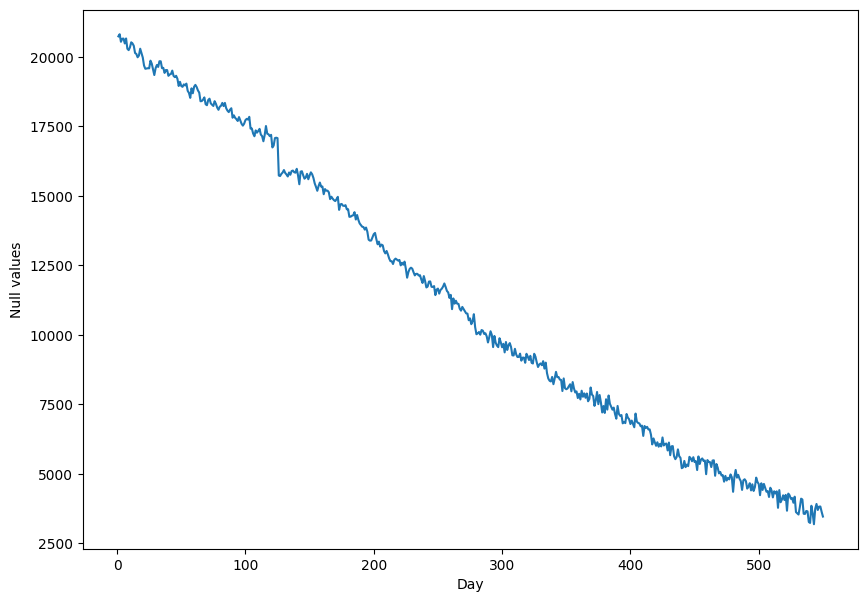

In [5]:
days = [r for r in range(1, len(train.columns))]
plot.figure(figsize=(10,7))
plot.xlabel('Day')
plot.ylabel('Null values')
plot.plot(days, train.isnull().sum()[1:])

We see that the number of nan values decrease with time.

**Probable reason:** Some website have all nan values in the begining, that can be due to the fact that those were created after that time so there is no traffic reading for that time

In [6]:
print(f'Before Dropping: {train.shape}')
train = train.dropna(how = 'all')

print(f'After Dropping the rows in which all values are Nulls: {train.shape}')

train = train.dropna(thresh=300)
print(f'After dropping the rows in which there are 300 or more nulls: {train.shape}')

Before Dropping: (145063, 551)
After Dropping the rows in which all values are Nulls: (145063, 551)
After dropping the rows in which there are 300 or more nulls: (133617, 551)


1. We try droping the rows that have all values as nan, none in our case.
2. We then also drop rows that have nan more than 300 days, because the time series for that would not make much sense
3. We fill all the remaining values with zero assuming there was no traffic on the date that the values are nan for.

In [7]:
train = train.fillna(0)
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
5,5566_zh.wikipedia.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,...,16.0,27.0,8.0,17.0,32.0,19.0,23.0,17.0,17.0,50.0


# EDA

 The page values are in this format **SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACESS TYPE _ ACCESS ORIGIN**  - having information about page name, the main domain, device type used to access the page, and also the request origin(spider or browser agent)


In [8]:
#Usage of Regex
def split_page(page):
    w = re.split('_|\.', page)
    print(w)
    return ' '.join(w[:-5]), w[-5], w[-2], w[-1]

# For Example
split_page('2NE1_zh.wikipedia.org_all-access_spider')

['2NE1', 'zh', 'wikipedia', 'org', 'all-access', 'spider']


('2NE1', 'zh', 'all-access', 'spider')

In [9]:
def split_page(page):
  w = re.split('_|\.', page)

  return ' '.join(w[:-5]), w[-5], w[-2], w[-1]

li = list(train.Page.apply(split_page))
df = pd.DataFrame(li)
df.columns = ['Title', 'Language', 'Access_type','Access_origin']
df = pd.concat([train, df], axis = 1)

We split the page name and get that information joining it with a temporary database.Below we get some rows to see the structure of the data

In [10]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Title,Language,Access_type,Access_origin
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,14.0,20.0,22.0,19.0,18.0,20.0,2NE1,zh,all-access,spider
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,9.0,30.0,52.0,45.0,26.0,20.0,2PM,zh,all-access,spider
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,4.0,4.0,6.0,3.0,4.0,17.0,3C,zh,all-access,spider
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,16.0,11.0,17.0,19.0,10.0,11.0,4minute,zh,all-access,spider
5,5566_zh.wikipedia.org_all-access_spider,12.0,7.0,4.0,5.0,20.0,8.0,5.0,17.0,24.0,...,32.0,19.0,23.0,17.0,17.0,50.0,A'N'D,zh,all-access,spider


<Axes: xlabel='Language', ylabel='count'>

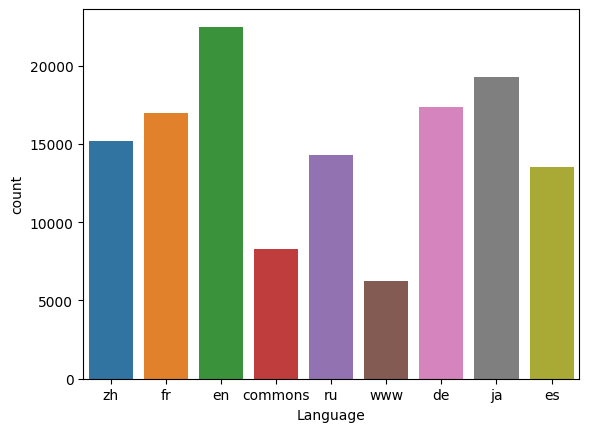

In [11]:
# Plot for Language

sns.countplot(data = df, x = 'Language')

This above is the comparision number of articles in each language

{'ja':'Japanese', 'de':'German',  'en' : 'English',  'no_lang':'Media_File',  'fr':'French',  'zh':'Chinese',  'ru':'Russian',  'es':'Spanish'}

<Axes: xlabel='Access_type', ylabel='count'>

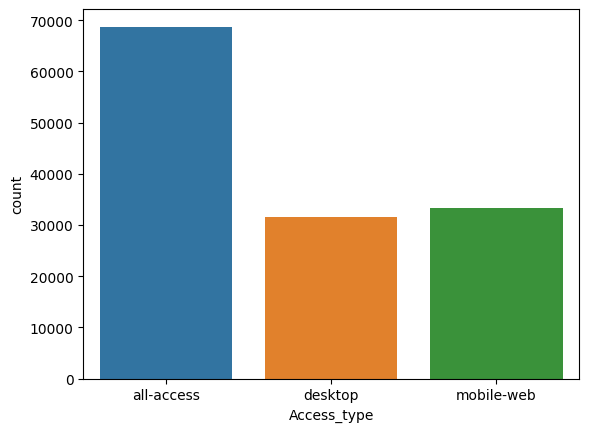

In [12]:
# Plot for Access Type

sns.countplot(data = df, x = 'Access_type')

This comparision shows that usage from desktop and mobile is almost the same

<Axes: xlabel='Access_origin', ylabel='count'>

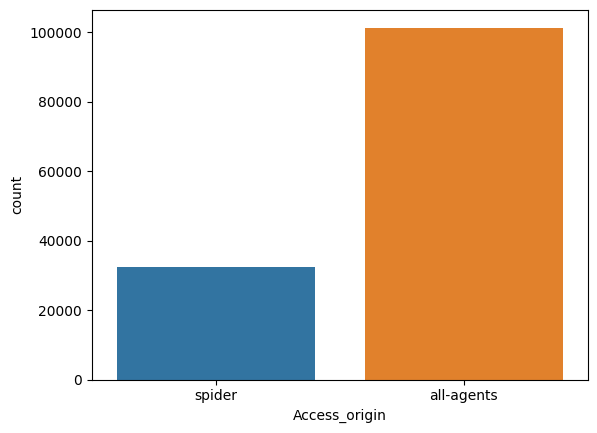

In [13]:
# Plot for Access Origin

sns.countplot(data = df, x = 'Access_origin')

This shows that organic view is far more than that of spiders or bots

**Now we want to compare the views for different languages**

In [14]:
#here we see that the languages are not treated properly as there are commons and www
df.groupby('Language').count()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Title,Access_type,Access_origin
Language,,,,,,,,,,,,,,,,,,,,,
commons,7672,7672,7672,7672,7672,7672,7672,7672,7672,7672,...,7672,7672,7672,7672,7672,7672,7672,8266,8266,8266
de,15946,15946,15946,15946,15946,15946,15946,15946,15946,15946,...,15946,15946,15946,15946,15946,15946,15946,17362,17362,17362
en,20758,20758,20758,20758,20758,20758,20758,20758,20758,20758,...,20758,20758,20758,20758,20758,20758,20758,22486,22486,22486
es,12268,12268,12268,12268,12268,12268,12268,12268,12268,12268,...,12268,12268,12268,12268,12268,12268,12268,13551,13551,13551
fr,15418,15418,15418,15418,15418,15418,15418,15418,15418,15418,...,15418,15418,15418,15418,15418,15418,15418,16948,16948,16948
ja,17132,17132,17132,17132,17132,17132,17132,17132,17132,17132,...,17132,17132,17132,17132,17132,17132,17132,19295,19295,19295
ru,12955,12955,12955,12955,12955,12955,12955,12955,12955,12955,...,12955,12955,12955,12955,12955,12955,12955,14270,14270,14270
www,5743,5743,5743,5743,5743,5743,5743,5743,5743,5743,...,5743,5743,5743,5743,5743,5743,5743,6228,6228,6228
zh,14845,14845,14845,14845,14845,14845,14845,14845,14845,14845,...,14845,14845,14845,14845,14845,14845,14845,15211,15211,15211


In [15]:
# Checking another way of fetching the language out of the string
def lang(Page):
    val = re.search('[a-z][a-z].wikipedia.org',Page)
    if val:
        return val[0][0:2]

    return 'no_lang'

df['Language']=df['Page'].apply(lambda x: lang(str(x)))

In [16]:
df.groupby('Language').count()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,Title,Access_type,Access_origin
Language,,,,,,,,,,,,,,,,,,,,,
de,17362,17362,17362,17362,17362,17362,17362,17362,17362,17362,...,17362,17362,17362,17362,17362,17362,17362,13046,13046,13046
en,22486,22486,22486,22486,22486,22486,22486,22486,22486,22486,...,22486,22486,22486,22486,22486,22486,22486,22486,22486,22486
es,13551,13551,13551,13551,13551,13551,13551,13551,13551,13551,...,13551,13551,13551,13551,13551,13551,13551,10142,10142,10142
fr,16948,16948,16948,16948,16948,16948,16948,16948,16948,16948,...,16948,16948,16948,16948,16948,16948,16948,16948,16948,16948
ja,19295,19295,19295,19295,19295,19295,19295,19295,19295,19295,...,19295,19295,19295,19295,19295,19295,19295,16140,16140,16140
no_lang,14494,14494,14494,14494,14494,14494,14494,14494,14494,14494,...,14494,14494,14494,14494,14494,14494,14494,25374,25374,25374
ru,14270,14270,14270,14270,14270,14270,14270,14270,14270,14270,...,14270,14270,14270,14270,14270,14270,14270,14270,14270,14270
zh,15211,15211,15211,15211,15211,15211,15211,15211,15211,15211,...,15211,15211,15211,15211,15211,15211,15211,15211,15211,15211


In [17]:
df_language=df.groupby('Language').mean().transpose()
df_language

Language,de,en,es,fr,ja,no_lang,ru,zh
2015-07-01,763.765926,3767.328604,1127.485204,499.092872,614.637160,102.733545,663.199229,272.498521
2015-07-02,753.362861,3755.158765,1077.485425,502.297852,705.813216,107.663447,674.677015,272.906778
2015-07-03,723.074415,3565.225696,990.895949,483.007553,637.451671,101.769629,625.329783,271.097167
2015-07-04,663.537323,3711.782932,930.303151,516.275785,800.897435,86.853871,588.171829,273.712379
2015-07-05,771.358657,3833.433025,1011.759575,506.871666,768.352319,96.254105,626.385354,291.977713
...,...,...,...,...,...,...,...,...
2016-12-27,1119.596936,6314.335275,1070.923400,840.590217,808.541436,155.270181,998.374071,363.066991
2016-12-28,1062.284069,6108.874144,1108.996753,783.585379,807.430163,178.561267,945.054730,369.049701
2016-12-29,1033.939062,6518.058525,1058.660320,763.209169,883.752786,150.873534,909.352207,340.526330
2016-12-30,981.786430,5401.792360,807.551177,710.502773,979.278777,156.049193,815.475123,342.745316


In [18]:
df_language.reset_index(inplace=True)
df_language.set_index('index', inplace=True)

Text(0, 0.5, 'Views per Page')

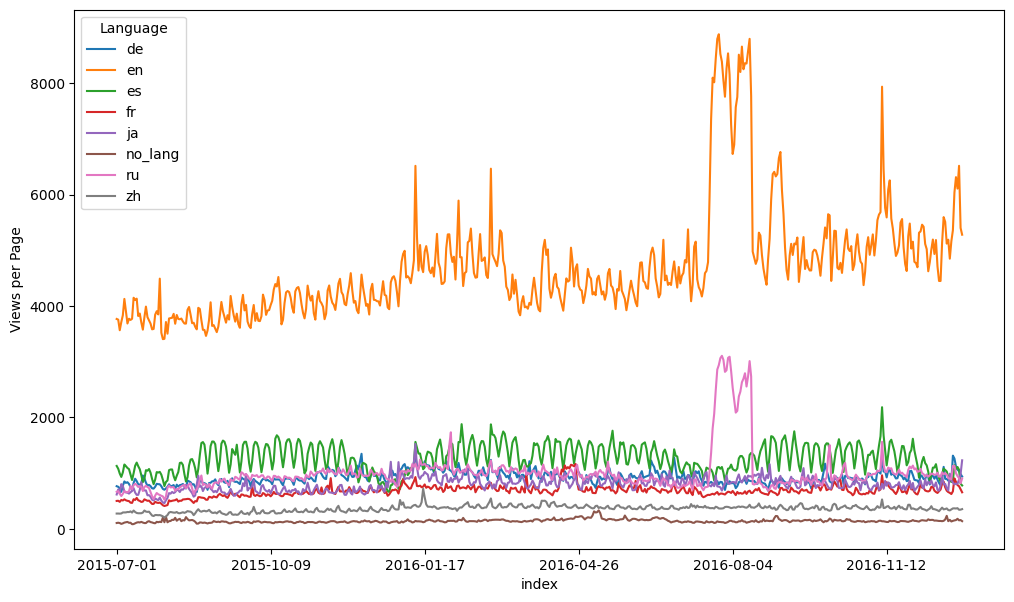

In [19]:
df_language.plot(figsize=(12,7))
plot.ylabel('Views per Page')

Ploting the data shows that articles in english get the most number of views as compared to different languages, there are some spikes at different times in different laguages

Ploting just for english because we are going to use this for our further investigation and predictions

Text(0, 0.5, 'Views per Page')

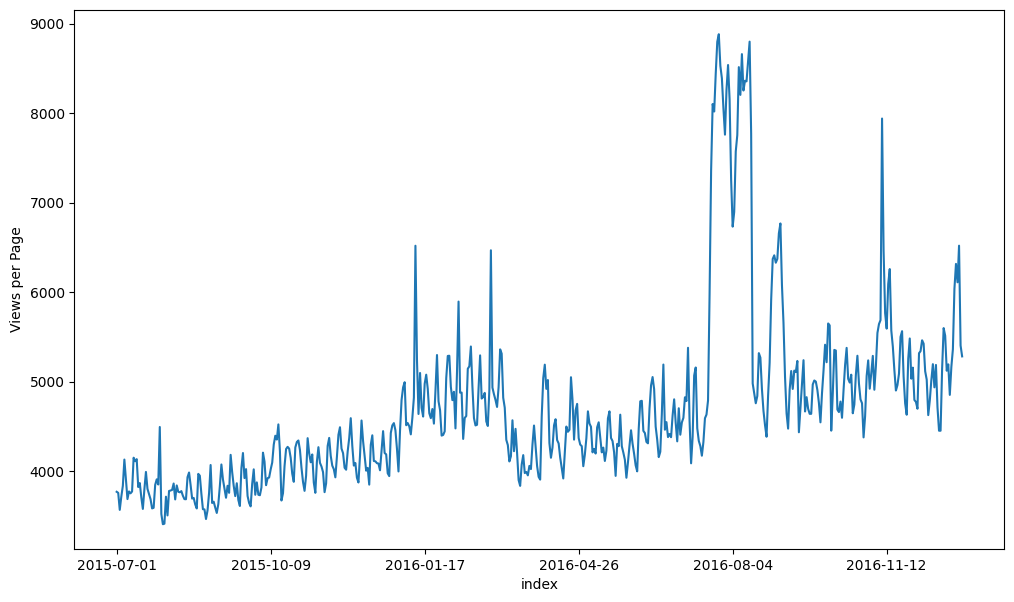

In [20]:
df_language['en'].plot(figsize=(12,7))
plot.ylabel('Views per Page')

In [21]:
total_view=df_language.copy()

## Checking the Stationarity

Dickey-Fuller test

**Null hypothesis - TS is non-stationary**:
The test results comprise of a Test Statistic and some Critical Values for difference confidence levels.


In [22]:
from statsmodels.tsa.stattools import adfuller
def df_test(x):
    result=adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])

df_test(total_view['en'])

ADF Stastistic: -2.373563
p-value: 0.149337


We see that the p value is not low enough(< 0.05)
Therefore, we can say our series in not stationary as we fail to reject the null hypothesis

## Stationarize the Time Series

In [23]:
ts=total_view[['en']]

### 1. Remove trend and seasonality with decomposition

In [24]:
ts = ts.reset_index()

In [25]:
ts.index = pd.to_datetime(ts.index)

In [26]:
ts.set_index('index', inplace=True)
ts

Language,en
index,
2015-07-01,3767.328604
2015-07-02,3755.158765
2015-07-03,3565.225696
2015-07-04,3711.782932
2015-07-05,3833.433025
...,...
2016-12-27,6314.335275
2016-12-28,6108.874144
2016-12-29,6518.058525


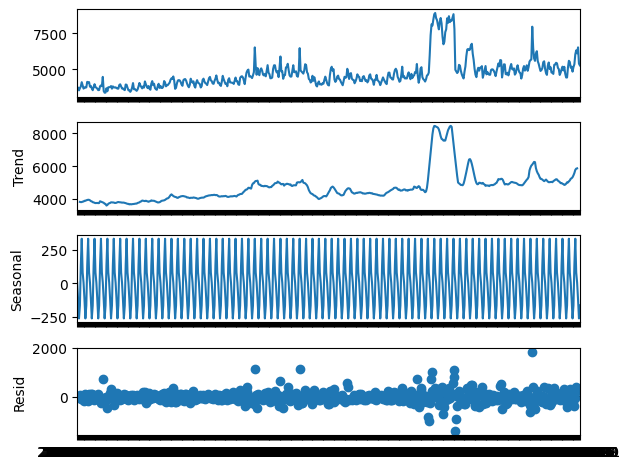

In [27]:
import statsmodels.api as sm
model = sm.tsa.seasonal_decompose(ts, period=7)
model.plot();

<Axes: xlabel='index'>

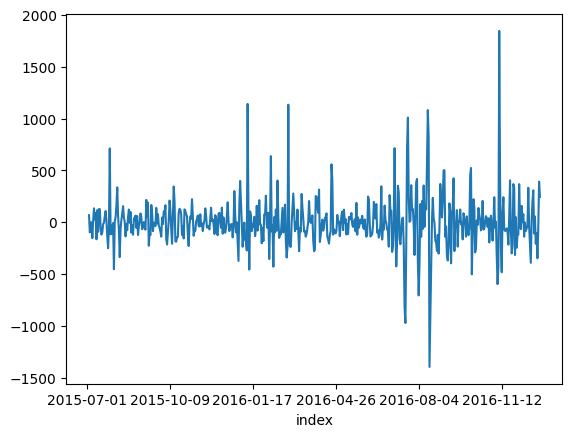

In [28]:
model.resid.plot()

In [29]:
df_test(model.resid.dropna())

ADF Stastistic: -11.437316
p-value: 0.000000


We can see that aur series is now stationary, we can also try diffrencing to see what results we can get.

### 2. Remove trend and seasonality with differencing

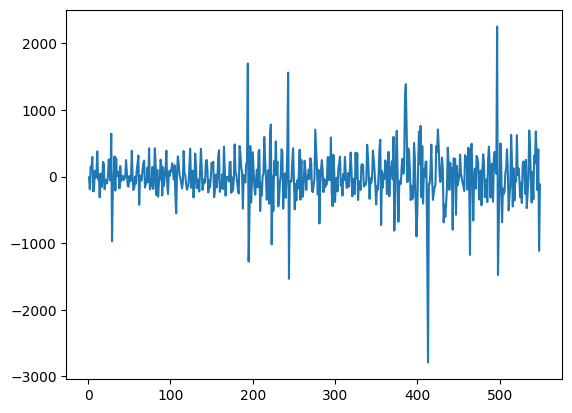

In [30]:
ts_diff = ts - ts.shift(1)
plot.plot(ts_diff.values)
plot.show()

In [31]:
ts_diff.dropna(inplace=True)
df_test(ts_diff)

ADF Stastistic: -8.273590
p-value: 0.000000


Also the p value is 0. So we can say that our graph is now stationery.
Now we can apply the ARIMA model

###  Plot the autocorreltaion and partial auto correlation functions

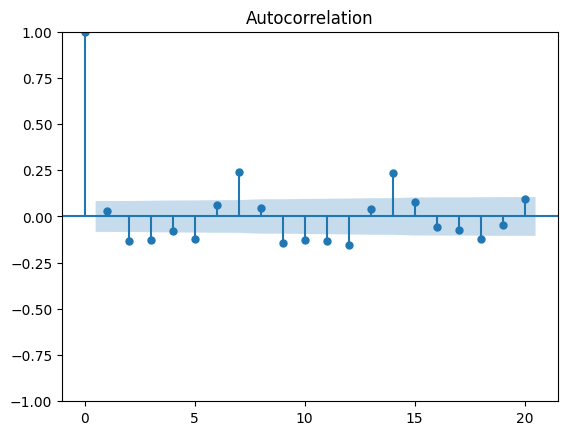

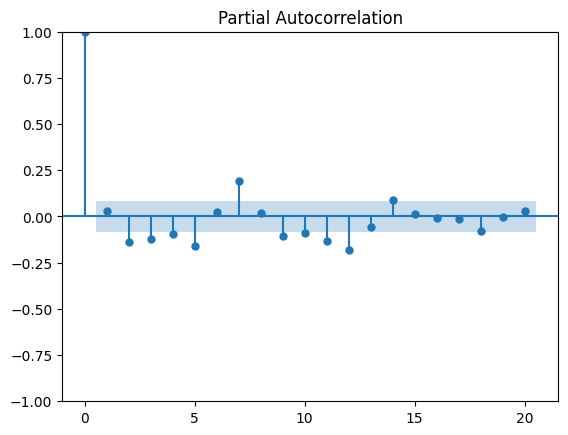

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf=plot_acf(ts_diff,lags=20)
pacf=plot_pacf(ts_diff,lags=20)

In [33]:
ts.diff(7)

Language,en
index,
2015-07-01,NaN
2015-07-02,NaN
2015-07-03,NaN
2015-07-04,NaN
2015-07-05,NaN
...,...
2016-12-27,803.065463
2016-12-28,988.209730
2016-12-29,1326.605088


## ARIMA Model

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas import DataFrame

In [35]:
model = SARIMAX(ts, order=(1,1,1))
model_fit = model.fit(disp=0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [36]:
model_fit.predict(12)
# plot.show()

2015-07-13    4107.969203
2015-07-14    4072.806185
2015-07-15    4095.745856
2015-07-16    3807.828134
2015-07-17    3849.974550
                 ...     
2016-12-27    5963.108761
2016-12-28    6216.994811
2016-12-29    6031.820932
2016-12-30    6405.618922
2016-12-31    5391.862247
Freq: D, Name: predicted_mean, Length: 538, dtype: float64

Multi step Forecasting

In [37]:
train = ts[:-20]
test = ts[-20:]

In ARMA family models, for getting p (Auto-regressive order) we look at PACF plot, there is a cut-off at lag1 due to which it will be considered as the order of AR in ARMA.

Similarly q(Moving Average order) will also be equal to 1 as the value of ACF at lag2 is significantly different from that at lag1. Therefore lag1 is also a cut-off point in ACF plot.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


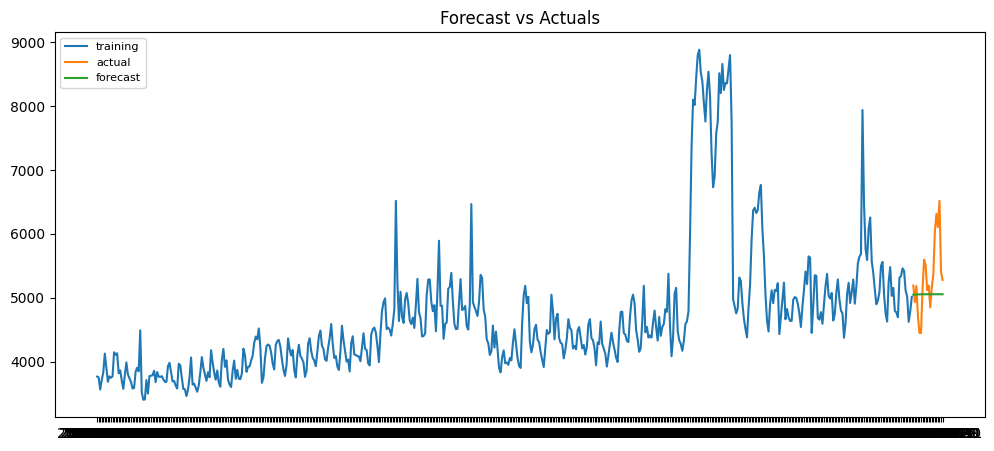

In [38]:
model = SARIMAX(train, order=(2, 1, 2))
fitted = model.fit(disp=-1)

# Forecast
fc = fitted.forecast(20, alpha=0.02)

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
# Plot
plot.figure(figsize=(12,5), dpi=100)
plot.plot(train, label='training')
plot.plot(test, label='actual')
plot.plot(fc_series, label='forecast')

plot.title('Forecast vs Actuals')
plot.legend(loc='upper left', fontsize=8)

In [39]:
mape = np.mean(np.abs(fc.values - test.values)/np.abs(test.values))
rmse = np.mean((fc.values - test.values)**2)**.5
print("mape:",mape)
print("rsme:",rmse)

mape: 0.08213040681122052
rsme: 614.4941148433043


- We can see that the model does not perform very well for multistep out sample data

- From the decomposition we can see that there is a weekly seasonality and still some spikes in the residual, that may be because of some external factors, which we can take into account by using them as our exogenous variable

In [40]:
ex_df = pd.read_csv('/content/Exog_Campaign_eng')
ex_df.head()

,Exog
0,0
1,0
2,0
3,0
4,0


In [41]:
exog=ex_df['Exog'].to_numpy()

we will train a sarimax model for that and see if we get anyimprovements from using the two information.

the seasonal order and the values of PDQ are based upon various trials and comparision of the models

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


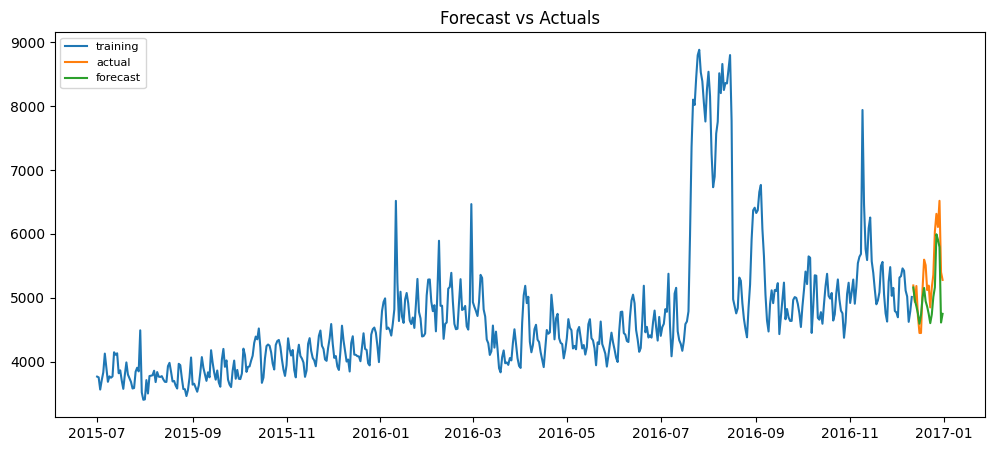

In [42]:
import statsmodels.api as sm
train=ts[:530]
test=ts[530:]
model=sm.tsa.statespace.SARIMAX(train,order=(1, 1, 1),seasonal_order=(1,1,1,7),exog=exog[:530])
results=model.fit()

fc=results.forecast(20,dynamic=True,exog=pd.DataFrame(exog[530:]))

# Make as pandas series
fc_series = pd.Series(fc)
# Plot
train.index=train.index.astype('datetime64[ns]')
test.index=test.index.astype('datetime64[ns]')
plot.figure(figsize=(12,5), dpi=100)
plot.plot(train, label='training')
plot.plot(test, label='actual')
plot.plot(fc_series, label='forecast')

plot.title('Forecast vs Actuals')
plot.legend(loc='upper left', fontsize=8)

In [43]:
mape = np.mean(np.abs(fc.values - test.values)/np.abs(test.values))
rmse = np.mean((fc.values - test.values)**2)**.5
print("mape:",mape)
print("rsme:",rmse)

mape: 0.10837143248589477
rsme: 752.6230226068652


The mean absolute percentage error and the root mean squared error is low

## Facebook Prophet

In [44]:
ts_df = ts.reset_index().copy()
ts_df.columns = [['ds', 'y']]

In [45]:
df2=ts_df.copy()
df2['exog'] = exog
df2.columns = ['ds', 'y', 'exog']
df2.head()

,ds,y,exog
0,2015-07-01,3767.328604,0
1,2015-07-02,3755.158765,0
2,2015-07-03,3565.225696,0
3,2015-07-04,3711.782932,0
4,2015-07-05,3833.433025,0


In [46]:
df2[:-20].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530 entries, 0 to 529
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      530 non-null    object 
 1   y       530 non-null    float64
 2   exog    530 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 12.5+ KB


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppebdoun1/lresj5ay.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppebdoun1/_a5wdggy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18576', 'data', 'file=/tmp/tmppebdoun1/lresj5ay.json', 'init=/tmp/tmppebdoun1/_a5wdggy.json', 'output', 'file=/tmp/tmppebdoun1/prophet_modelfi3nie6h/prophet_model-20230916144853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:48:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:48:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


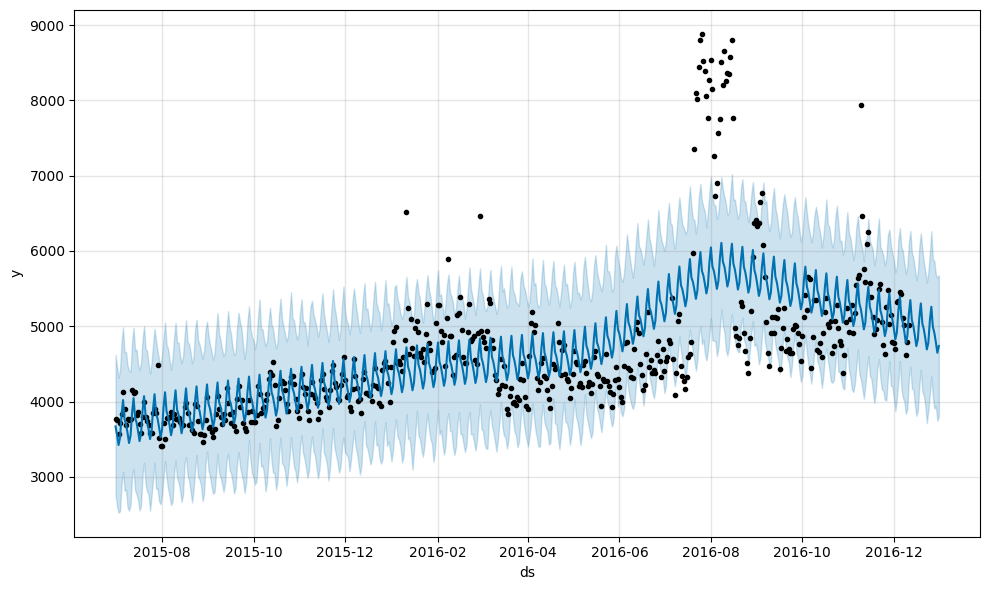

In [47]:
from prophet import Prophet
m = Prophet(weekly_seasonality=True)
m.fit(df2[['ds', 'y']][:-20])
future = m.make_future_dataframe(periods=20,freq="D")
forecast = m.predict(future)
fig = m.plot(forecast)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppebdoun1/decr6pau.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppebdoun1/dwee61fv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41994', 'data', 'file=/tmp/tmppebdoun1/decr6pau.json', 'init=/tmp/tmppebdoun1/dwee61fv.json', 'output', 'file=/tmp/tmppebdoun1/prophet_modelvhh8cgtm/prophet_model-20230916144905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:49:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:49:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


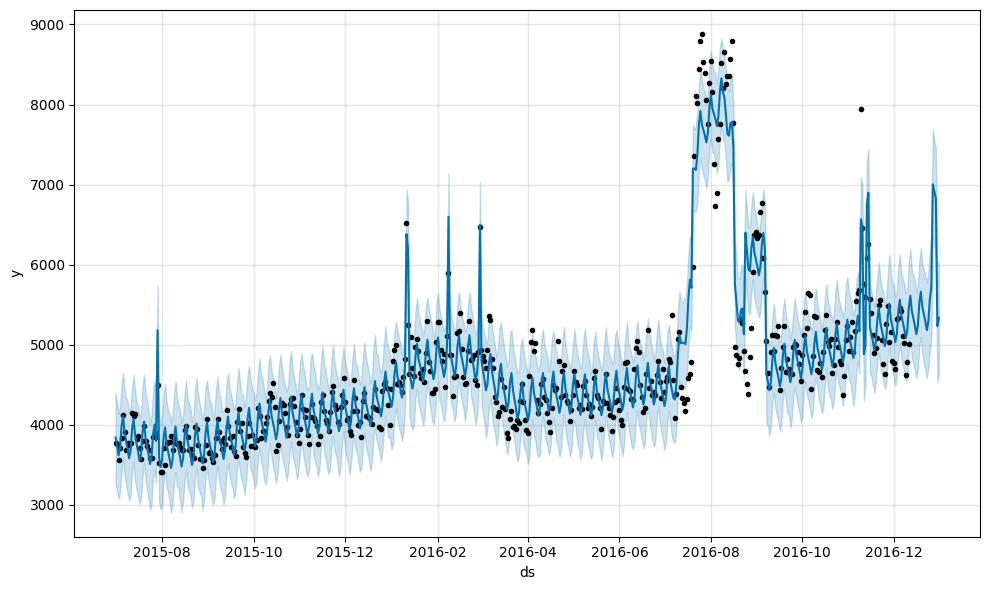

In [48]:
model2=Prophet(interval_width=0.9, weekly_seasonality=True, changepoint_prior_scale=1)
model2.add_regressor('exog')
model2.fit(df2[:-20])
forecast2 = model2.predict(df2)
fig = model2.plot(forecast2)

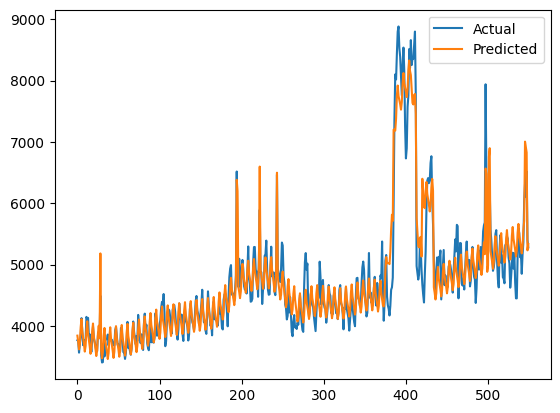

In [49]:
y_true = df2['y'].values
y_pred = forecast2['yhat'].values

plot.plot(y_true, label='Actual')
plot.plot(y_pred, label='Predicted')
plot.legend()
plot.show()

In [50]:
mape = np.mean(np.abs(forecast2['yhat'][-20:] - df2['y'][-20:].values)/np.abs(df2['y'][-20:].values))
print("mape:",mape)

mape: 0.06645966119841304


## Comparing the Predicted Views for Different Languages

In [51]:
def grid_search(ts):
    v=[0,1,2,3]
    mape=100
    val=[0,0,0]
    for p in v:
        for d in v:
            for q in v:
                try:
                    model = SARIMAX(ts[:-20], order=(p,d,q))
                    model_fit = model.fit(disp=-1)
                    fc = model_fit.forecast(20, alpha=0.02)
                    x = np.mean(np.abs(fc.values - ts[-20:].values)/np.abs(ts[-20:].values))
                    if(x<mape):
                        mape=x
                        val=[p,d,q]

                except:
                    pass

    return(mape, val)

In [52]:
def all_arima(train,test,val):
    model = SARIMAX(train, order=(val[0], val[1], val[2]))
    fitted = model.fit(disp=-1)

  # Forecast
    fc = fitted.forecast(20, alpha=0.02)



    fc_series = pd.Series(fc.values, index=test.index)

  # Plot
    plot.figure(figsize=(12,5), dpi=100)
    plot.plot(train, label='training')
    plot.plot(test, label='actual')
    plot.plot(fc_series, label='forecast')
    plot.title('Forecast vs Actuals')
    plot.legend(loc='upper left', fontsize=8)
    plot.show()
    mape = np.mean(np.abs(fc.values - test.values)/np.abs(test.values))
    rmse = np.mean((fc.values - test.values)**2)**.5
    print("mape:",mape)
    print("rsme:",rmse)
    return (fc)


language:  de
0.09353360095431812 [3, 2, 3]


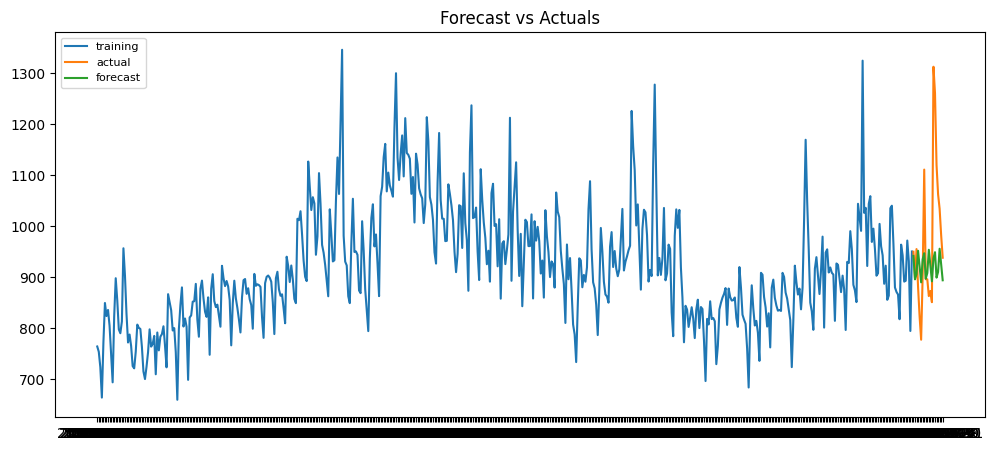

mape: 0.09353360095431812
rsme: 140.02830661470372
language:  en
0.07223427697118105 [1, 1, 1]


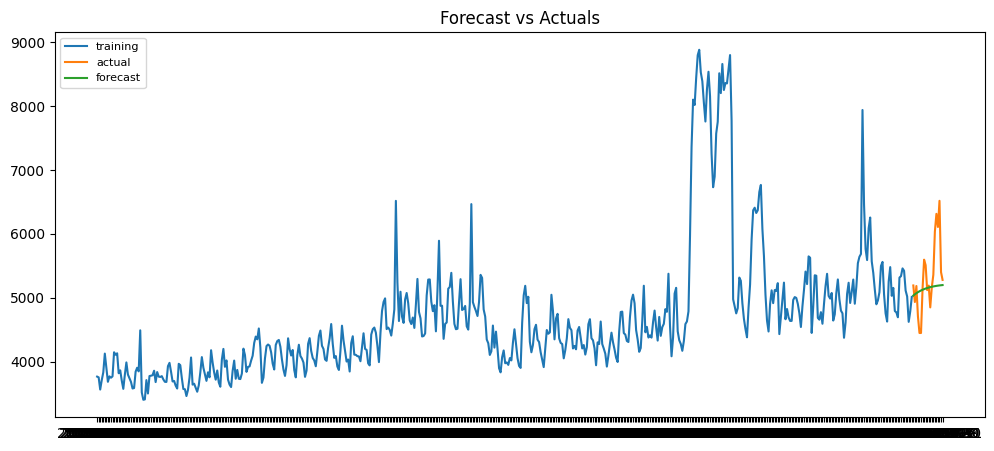

mape: 0.07223427697118105
rsme: 556.2662052582948
language:  es
0.08200017536334264 [3, 2, 3]


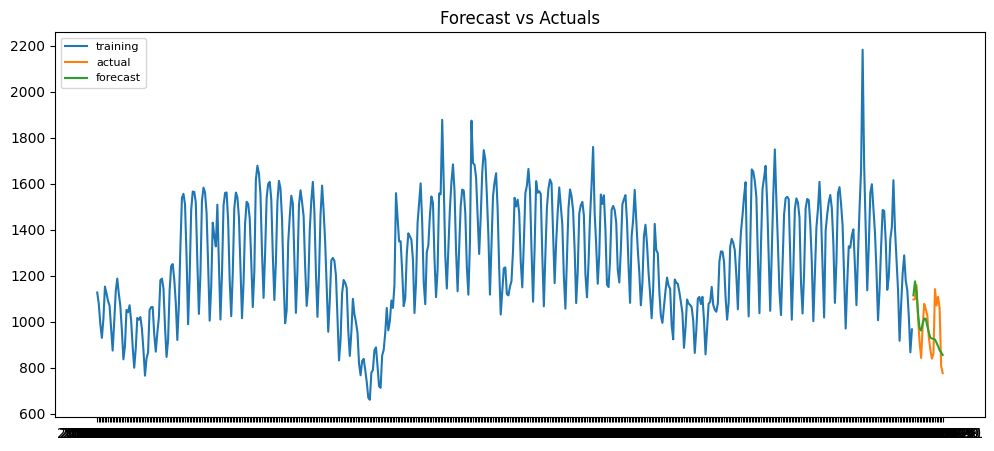

mape: 0.08200017536334264
rsme: 102.90488099458243
language:  fr
0.08548426058302927 [3, 0, 1]


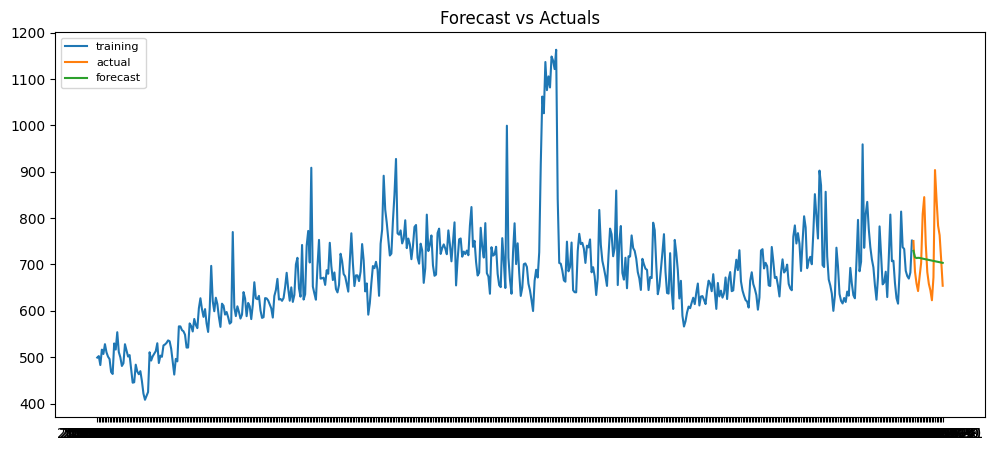

mape: 0.08548426058302927
rsme: 78.83429850249246
language:  ja
0.09361914217195821 [2, 1, 2]


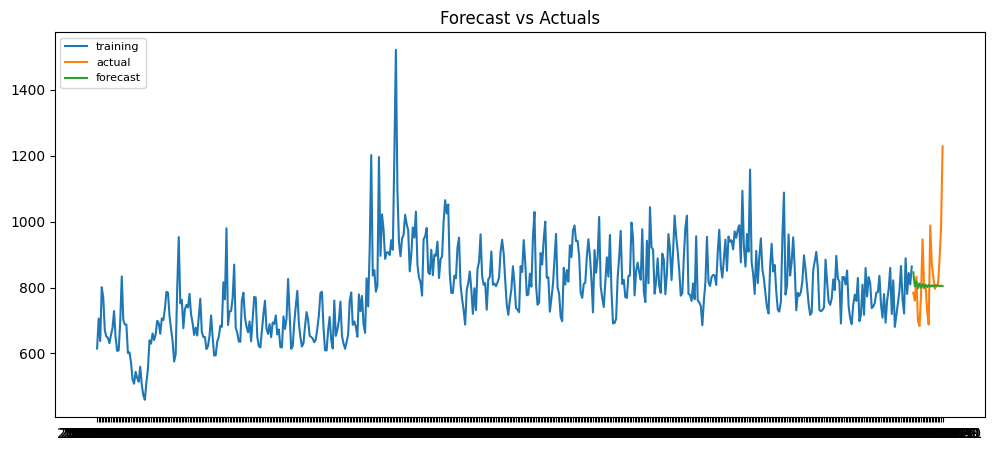

mape: 0.09361914217195821
rsme: 128.0040431238317
language:  no_lang
0.079547052597764 [2, 0, 3]


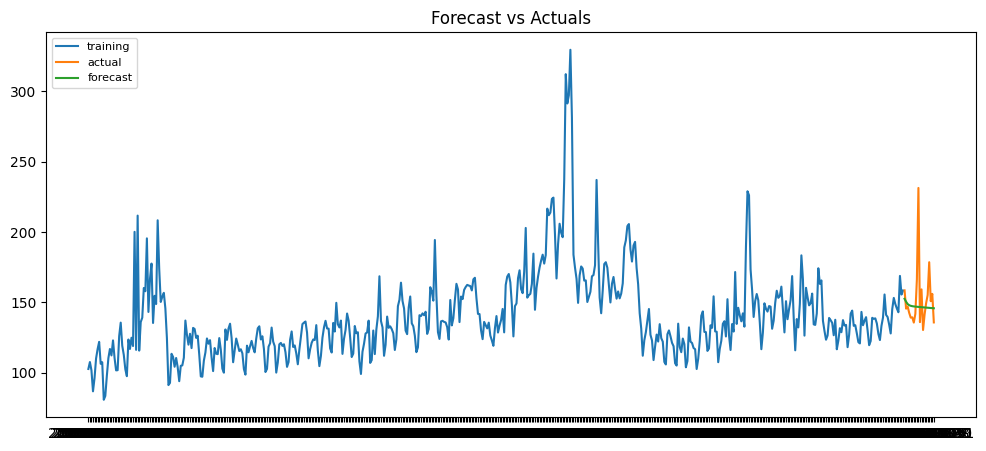

mape: 0.079547052597764
rsme: 22.16610622035315
language:  ru
0.05038701858487434 [3, 3, 2]


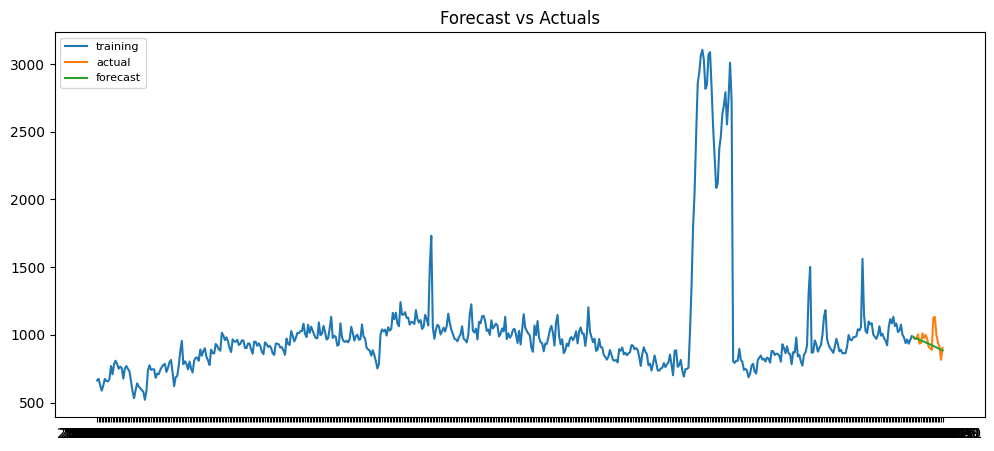

mape: 0.05038701858487434
rsme: 77.9173226189771
language:  zh
0.049179269380012804 [3, 0, 3]


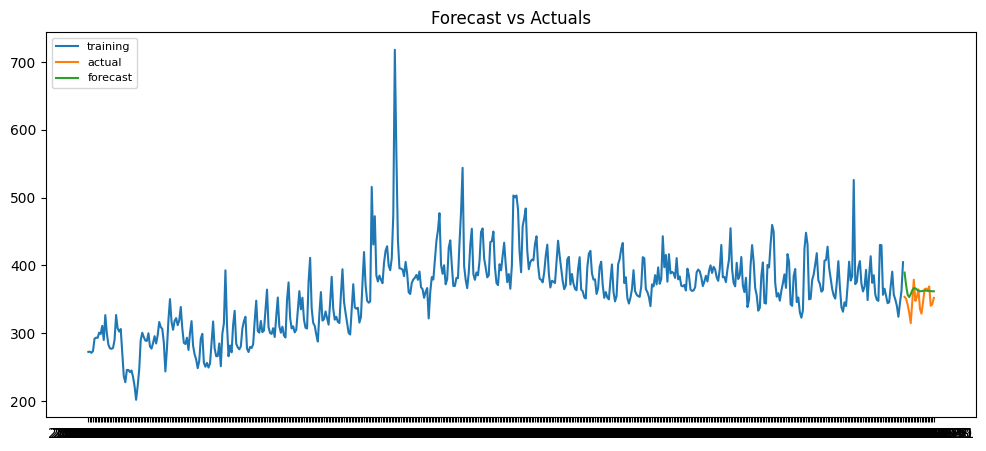

mape: 0.049179269380012804
rsme: 20.227944843798802


In [53]:
import warnings
warnings.filterwarnings("ignore")
views_prediction={}
for c in total_view:
    print("language: ",c)
    ts=(total_view[c])
    mape,val=grid_search(ts)
    print(mape,val)
    train = ts[:530]
    test = ts[530:]
    fc=all_arima(train,test,val)
    views_prediction[c]=fc